In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
from where import WhereFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten 
from where import RetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer

In [5]:
from main import init
args = init(filename='../data/2019-06-05')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 15,
 'offset_max': 40,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.0001,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

In [6]:
from retina import Retina
retina = Retina(args)

In [7]:
accuracy_map = np.load('../data/MNIST_accuracy.npy')

In [8]:
accuracy_map.min()

0.0145

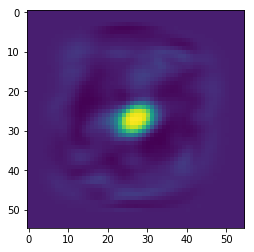

In [9]:
plt.imshow(accuracy_map)

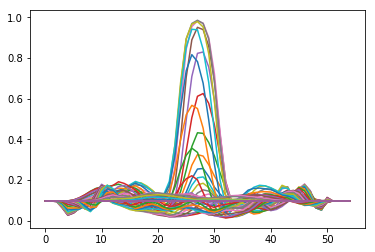

In [10]:
_ = plt.plot(accuracy_map)

## Unit tests

In [11]:
import math

In [12]:
i_offset = -18 #None #
j_offset = 18 #None #

In [13]:
transform=transforms.Compose([
                               WhereFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground(),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [14]:
target_transform=transforms.Compose([
                               WhereFill(accuracy_map=accuracy_map, N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4, baseline = 0.1),
                               #WhereShift(args, radius = 18, baseline = 0.1),
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset, baseline = 0.1),
                               CollTransform(retina.colliculus_transform_vector),
                           ])

In [15]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [16]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [17]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [18]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [19]:
data, label = next(iter(train_loader))

In [20]:
data.shape

torch.Size([100, 2880])

In [21]:
#plt.imshow(data[i,:,:].detach().numpy())

In [22]:
label.shape

torch.Size([100, 240])

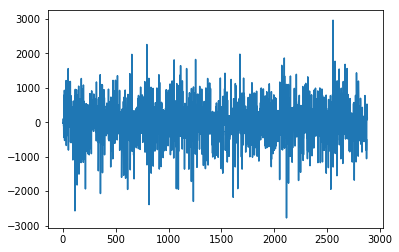

In [23]:
i = 7
plt.plot(data[i,:].detach().numpy())


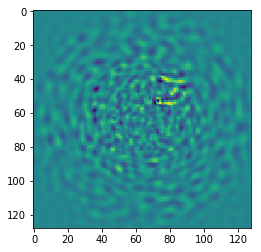

In [24]:
plt.imshow(retina.retina_invert(data[i,:].detach().numpy()))

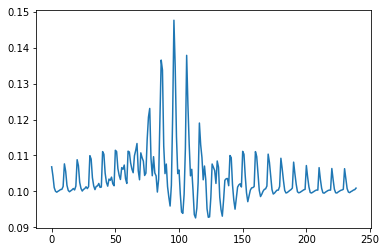

In [25]:
plt.plot(label[i,:].detach().numpy())

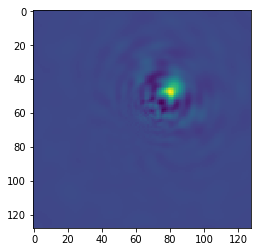

In [26]:
plt.imshow(retina.accuracy_invert(label[i,:].detach().numpy()))

(array([4.000e+00, 1.500e+01, 5.600e+01, 2.640e+02, 1.672e+03, 6.380e+02,
        1.970e+02, 2.700e+01, 6.000e+00, 1.000e+00]),
 array([-2776.72873038, -2203.38974821, -1630.05076605, -1056.71178388,
         -483.37280171,    89.96618046,   663.30516263,  1236.6441448 ,
         1809.98312697,  2383.32210913,  2956.6610913 ]),
 <a list of 10 Patch objects>)

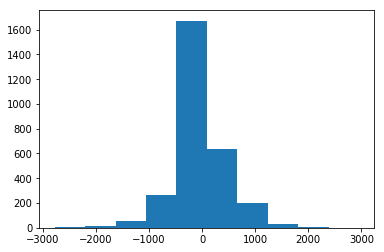

In [27]:
plt.hist(data[i,:].detach().numpy().flatten())

## WhereTrainer Class test

In [ ]:
whereTrainer = WhereTrainer(args, generate_data=True)

Generating training dataset
0 100
1 200
2 300
3 400
4 500
5 600
6 700
7 800
8 900
9 1000
10 1100
11 1200
12 1300
13 1400
14 1500
15 1600
16 1700
17 1800
18 1900
19 2000
20 2100
21 2200
22 2300
23 2400
24 2500
25 2600
26 2700
27 2800
28 2900
29 3000
30 3100
31 3200
32 3300
33 3400
34 3500
35 3600
36 3700
37 3800
38 3900
39 4000
40 4100
41 4200
42 4300
43 4400
44 4500
45 4600
46 4700


In [29]:
whereTrainer.model

WhereNet(
  (bn1): Linear(in_features=2880, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=240, bias=True)
)

In [30]:
whereTrainer.loss_func

BCEWithLogitsLoss()

In [31]:
whereTrainer.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [32]:
data, label = next(iter(whereTrainer.test_loader))

In [33]:
data.shape

torch.Size([100, 2880])

In [34]:
label.min()

tensor(0.0464)

In [35]:
output = whereTrainer.model(data)

In [36]:
output.shape

torch.Size([100, 240])

In [37]:
output.max()

tensor(1.7664, grad_fn=<MaxBackward1>)

In [38]:
loss_func = torch.nn.BCEWithLogitsLoss()
loss = loss_func(output, label)

In [39]:
if False:
    from where import train
    train(args, 
          whereTrainer.model, 
          "cpu", 
          whereTrainer.train_loader, 
          whereTrainer.loss_func, 
          whereTrainer.optimizer, 
          1)

In [40]:
if False:
    for epoch in range(1, 2): #args.epochs + 1):
        whereTrainer.train(epoch)
        whereTrainer.test()

In [42]:
whereTrainer.test()

Testing on 0.0% of the test dataset.
Testing on 16.666666666666668% of the test dataset.
Testing on 33.333333333333336% of the test dataset.


KeyboardInterrupt: 

## Dataset generation

In [ ]:
if False:
    for i, (data, label) in enumerate(train_loader):
        print(i, (i+1) * args.minibatch_size)
        if i == 0:
            full_data = data
            full_label = label
        else:
            full_data = torch.cat((full_data, data), 0)
            full_label = torch.cat((full_label, label), 0)

In [ ]:
dataset = TensorDataset(full_data, full_label)
data_loader = DataLoader(dataset, batch_size=args.minibatch_size)

In [ ]:
full_data.shape

In [ ]:
data, label = next(iter(data_loader))

In [ ]:
data.shape

In [ ]:
plt.plot(label[i,:].detach().numpy())

In [ ]:
np.random.seed(26722)
np.random.randn()

In [ ]:
from display import pe, minmax
minmax(-15, 10)